In [1]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model, naive_bayes, metrics, svm, ensemble 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class ShowData():
    def __init__(self, file):
        self.data = pd.read_csv(file)

    def CurrentData(self):
        return self.data

    def Distribution(self, col_name):
        unique_types = self.data[col_name].nunique()
        self.data[col_name].hist(bins= unique_types) 
    
    def AVGData(self, col_name):
        self.data[col_name].plot.box() 
        
    def DeleteColumn(self, col_names):
        if isinstance(col_names, str):
            col_names = [col_names]
        self.data.drop(columns=col_names, axis=1, inplace = True)
    
    def ShowMatrix(self):
        correlations = self.data.corr()
        fig, ax = plt.subplots(figsize=(10, 10))
        colormap = sns.color_palette("BrBG", 10)
        sns.heatmap(correlations, 
            cmap=colormap, 
            annot=True, 
            fmt=".2f")
        ax.set_yticklabels(self.data.columns)
        plt.show()

In [3]:
data = ShowData('cancer_patient_data_sets.csv')
data.CurrentData().head()

index Patient Id  Age  Gender  Air Pollution  Alcohol use  Dust Allergy  \
0      0         P1   33       1              2            4             5   
1      1        P10   17       1              3            1             5   
2      2       P100   35       1              4            5             6   
3      3      P1000   37       1              7            7             7   
4      4       P101   46       1              6            8             7   

   OccuPational Hazards  Genetic Risk  chronic Lung Disease  ...  Fatigue  \
0                     4             3                     2  ...        3   
1                     3             4                     2  ...        1   
2                     5             5                     4  ...        8   
3                     7             6                     7  ...        4   
4                     7             7                     6  ...        3   

   Weight Loss  Shortness of Breath  Wheezing  Swallowing Difficulty  \
0            4                    2         2                      3   
1            3                    7         8                      6   
2            7                    9         2                      1   
3            2                    3         1                      4   
4            2                    4         1                      4   

   Clubbing of Finger Nails  Frequent Cold  Dry Cough  Snoring   Level  
0                         1              2          3        4     Low  
1                         2              1          7        2  Medium  
2                         4              6          7        2    High  
3                         5              6          7        5    High  
4                         2              4          2        3    High  

[5 rows x 26 columns]

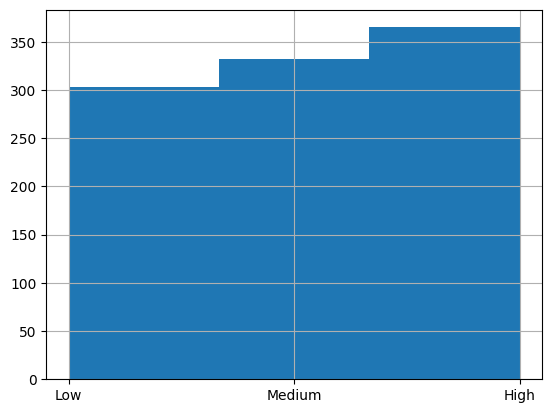

In [4]:
data.Distribution('Level')

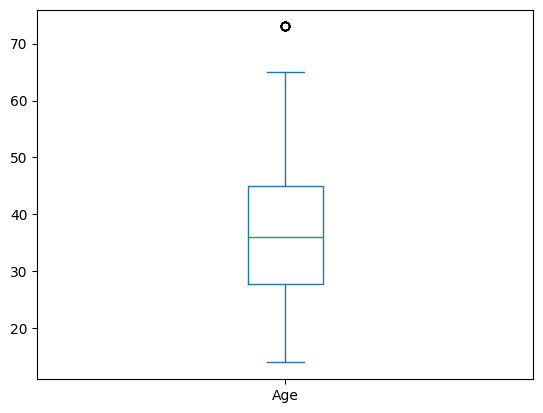

In [5]:
data.AVGData('Age')

In [6]:
data.DeleteColumn('index')
data.DeleteColumn(['Air Pollution','Patient Id','Gender','Dust Allergy','OccuPational Hazards','Genetic Risk','chronic Lung Disease','Balanced Diet','Chest Pain','Coughing of Blood','Fatigue','Shortness of Breath','Wheezing','Swallowing Difficulty','Clubbing of Finger Nails','Frequent Cold','Dry Cough','Snoring'])

data.CurrentData().head()

Age  Alcohol use  Obesity  Smoking  Passive Smoker  Weight Loss   Level
0   33            4        4        3               2            4     Low
1   17            1        2        2               4            3  Medium
2   35            5        7        2               3            7    High
3   37            7        7        7               7            2    High
4   46            8        7        8               7            2    High

In [7]:
try:
    # Reverse mapping from numerical values back to string labels
    maps = {'Low': 0, 'Medium': 1, 'High': 2}
    data.CurrentData()['Level'] = data.CurrentData()['Level'].apply(lambda x: maps[x])

except:
    pass


data.CurrentData().head()

Age  Alcohol use  Obesity  Smoking  Passive Smoker  Weight Loss  Level
0   33            4        4        3               2            4      0
1   17            1        2        2               4            3      1
2   35            5        7        2               3            7      2
3   37            7        7        7               7            2      2
4   46            8        7        8               7            2      2

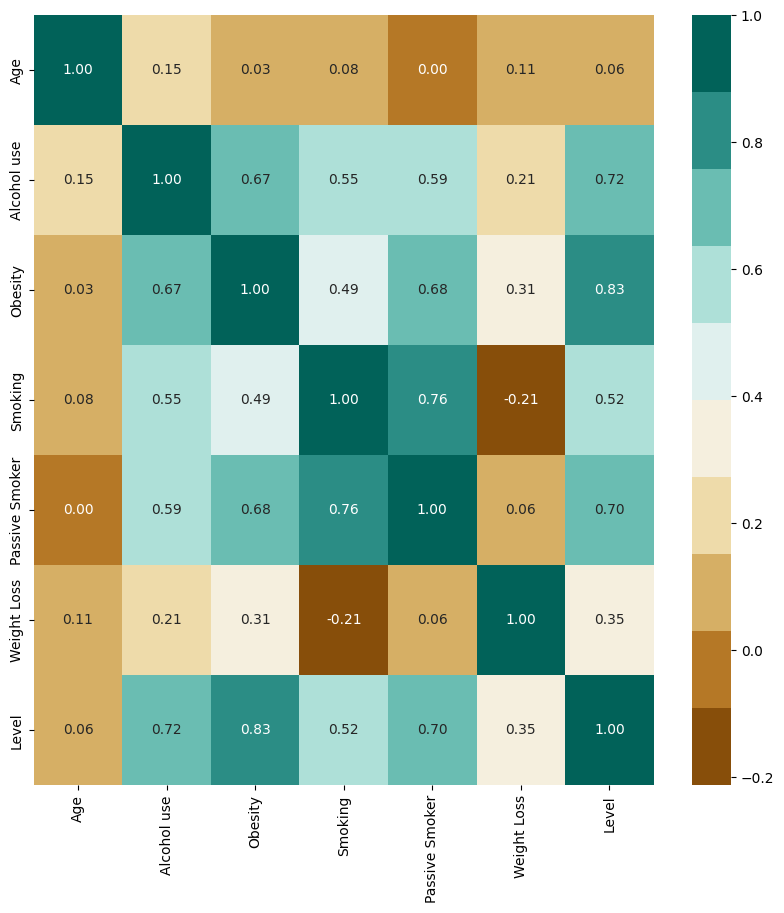

In [8]:
data.ShowMatrix()

In [9]:
class MainTrainingModel:
    def __init__(self, data_base, predicting_col_name, transform = False):
        self.database = data_base
        self.predicting_col_name = predicting_col_name
        data_X = self.database.drop(predicting_col_name, axis=1).to_numpy()
        data_y = self.database.loc[:, predicting_col_name].to_numpy()
        if(transform):
            data_X = preprocessing.QuantileTransformer(n_quantiles=min(100, len(data_X))).fit_transform(data_X)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(data_X, data_y, test_size=0.20, random_state=12345)
        self.accuracy_compare = {}
        
    def train_model(self, classifier):

        classifier.fit(self.X_train, self.y_train)
        
        predictions = classifier.predict(self.X_test)
        
        scores = list(metrics.precision_recall_fscore_support(predictions, self.y_test))
        score_vals = [
            scores[0][0],
            scores[1][0],
            scores[2][0]
        ]
        score_vals.append(metrics.accuracy_score(predictions, self.y_test))
        return score_vals, predictions
    
    # MODEL 1 - logistic regression
    def LogisticRegression(self):
        self.linier_accuracy, predictions = self.train_model(linear_model.LogisticRegression(max_iter=10000))
        self.accuracy_compare['LR'] = self.linier_accuracy
        return predictions

    # MODEL 2 - Support Vector Machine
    def SupportVectorMachine(self):
        self.svc_accuracy, predictions = self.train_model(svm.SVC(max_iter=10000))
        self.accuracy_compare['SVC'] = self.svc_accuracy
        return predictions

    # MODEL 3 - neural network
    def NeutralNetwork(self):  # Fix typo in method name
        from sklearn.neural_network import MLPClassifier
        mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=10000)
        self.nn_accuracy, predictions = self.train_model(mlp)
        self.accuracy_compare['neural network'] = self.nn_accuracy
        return predictions

    def ShowData(self):
        df_compare = pd.DataFrame(self.accuracy_compare, index=['precision', 'recall', 'f1 score', 'accuracy'])
        df_compare.plot(kind='bar')
        print(pd.DataFrame(self.accuracy_compare).head())

    def TrainAllDataModles(self):
        self.LogisticRegression()
        self.SupportVectorMachine()
        self.NeutralNetwork()
        self.ShowData()

    def ShowPredictionScore(self, predictions, col_name1, col_name2):

        col_index1 = self.database.columns.get_loc(col_name1)
        col_index2 = self.database.columns.get_loc(col_name2)
        
        plt.subplot(1, 2, 1)
        plt.scatter(self.X_test[:, col_index1], self.X_test[:, col_index2], c=self.y_test)
        plt.title('True Labels')
        plt.xlabel(col_name1)
        plt.ylabel(col_name2)
        plt.colorbar(label=self.predicting_col_name)

        plt.subplot(1, 2, 2)
        plt.scatter(self.X_test[:, col_index1], self.X_test[:, col_index2], c=predictions)
        plt.title('Predicted Labels')
        plt.xlabel(col_name1)
        plt.ylabel(col_name2)
        plt.colorbar(label=self.predicting_col_name)

        plt.tight_layout()
        plt.show()


In [10]:
data.CurrentData()

Age  Alcohol use  Obesity  Smoking  Passive Smoker  Weight Loss  Level
0     33            4        4        3               2            4      0
1     17            1        2        2               4            3      1
2     35            5        7        2               3            7      2
3     37            7        7        7               7            2      2
4     46            8        7        8               7            2      2
..   ...          ...      ...      ...             ...          ...    ...
995   44            7        7        7               8            3      2
996   37            8        7        7               8            6      2
997   25            5        7        2               3            7      2
998   18            8        7        8               7            2      2
999   47            5        7        2               3            7      2

[1000 rows x 7 columns]

In [11]:
model = MainTrainingModel(data.CurrentData(), "Level")
model2 = MainTrainingModel(data.CurrentData(), "Level", transform = True)

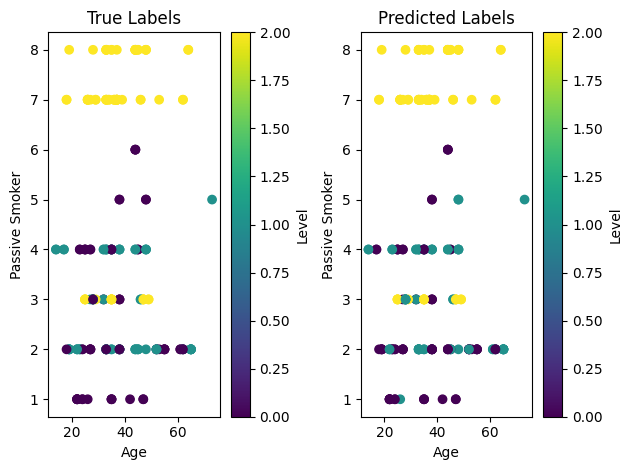

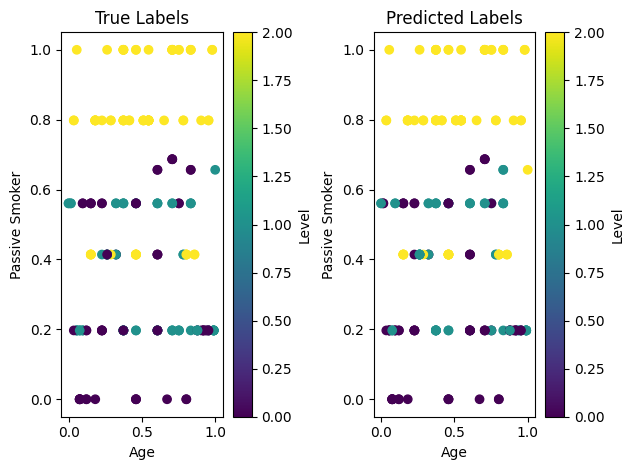

In [12]:
progression = model.LogisticRegression()
progression2 = model2.LogisticRegression()
# progression = model.SupportVectorMachine()
# progression = model.NeutralNetwork()

model.ShowPredictionScore(progression, "Age", "Passive Smoker")
model2.ShowPredictionScore(progression2, "Age", "Passive Smoker")

         LR       SVC  neural network
0  0.764706  0.852941        0.970588
1  0.753623  0.753247        0.970588
2  0.759124  0.800000        0.970588
3  0.835000  0.770000        0.980000
         LR       SVC  neural network
0  0.779412  0.867647             1.0
1  0.757143  1.000000             1.0
2  0.768116  0.929134             1.0
3  0.835000  0.955000             1.0


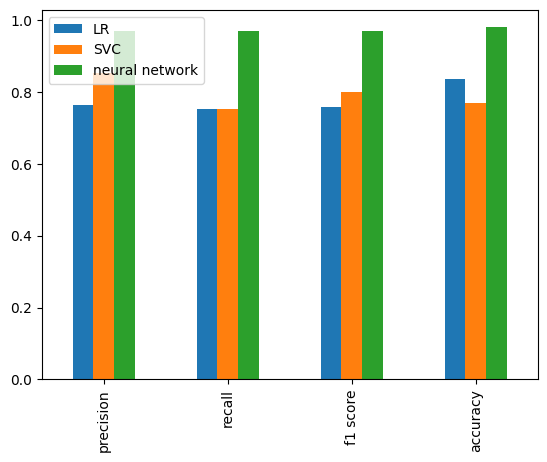

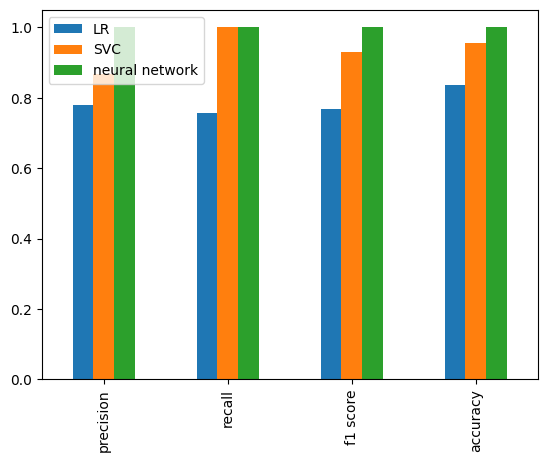

In [13]:
model.TrainAllDataModles()
model2.TrainAllDataModles()

In [14]:
import unittest
import warnings
from sklearn.exceptions import UndefinedMetricWarning

class TestMainTrainingModel(unittest.TestCase):

    def setUp(self):
        data = {
            'Age': [33, 17, 35, 37, 46, 28, 42, 20, 55, 60],
            'Alcohol use': [4, 1, 5, 7, 8, 2, 6, 3, 9, 7],
            'Obesity': [4, 2, 7, 7, 7, 3, 6, 2, 8, 5],
            'Smoking': [3, 2, 2, 7, 8, 1, 5, 2, 7, 4],
            'Passive Smoker': [2, 4, 3, 7, 7, 1, 3, 2, 6, 5],
            'Weight Loss': [4, 3, 7, 2, 2, 1, 5, 3, 8, 6],
            'Level': [0, 1, 2, 2, 2, 1, 0, 1, 2, 1]
        }

        self.sample_data = pd.DataFrame(data)

        self.model = MainTrainingModel(self.sample_data, "Level")


    def test_LogisticRegression(self):
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        predictions = self.model.LogisticRegression()
        self.assertIsNotNone(predictions)

    def test_SupportVectorMachine(self):
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        predictions = self.model.SupportVectorMachine()
        self.assertIsNotNone(predictions)
        

    def test_NeutralNetwork(self):
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        predictions = self.model.NeutralNetwork()
        self.assertIsNotNone(predictions)
        
        
    def test_Transform(self):
        warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
        model_transform = MainTrainingModel(self.sample_data, "Level", transform = True)
        predictions = model_transform.LogisticRegression()
        self.assertIsNotNone(predictions)


test_suite = unittest.TestLoader().loadTestsFromTestCase(TestMainTrainingModel)
unittest.TextTestRunner(verbosity=2).run(test_suite)

test_LogisticRegression (__main__.TestMainTrainingModel.test_LogisticRegression) ... ok
test_NeutralNetwork (__main__.TestMainTrainingModel.test_NeutralNetwork) ... ok
test_SupportVectorMachine (__main__.TestMainTrainingModel.test_SupportVectorMachine) ... ok
test_Transform (__main__.TestMainTrainingModel.test_Transform) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.205s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>